In [1]:
import pandas as pd
from matplotlib import pyplot
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from category_encoders import OneHotEncoder
import pickle
import os

In [2]:
%cd ../../

/Users/mubasir/Desktop/ONDC-hackathon


In [3]:
E_Kart = pd.read_csv(os.path.join("data", "logistic_data", "E-Kart.csv"))
E_Kart.head()

,Date,Logistic Partner,Distance in km,City,weather,Wieght,Holiday,Population Density,Charge / Cost in Rupees
0,01/01/2021,E-Kart,4,Mumbai,winter,25,no,25357,149.357
1,01/02/2021,E-Kart,4,Mumbai,winter,20,no,25357,129.357
2,01/03/2021,E-Kart,4,Mumbai,winter,19,yes,25357,125.357
3,01/04/2021,E-Kart,4,Mumbai,winter,18,no,25357,121.357
4,01/05/2021,E-Kart,4,Mumbai,winter,16,no,25357,113.357


In [4]:
E_Kart.sort_values(by = ["Date"], inplace=True)
E_Kart

,Date,Logistic Partner,Distance in km,City,weather,Wieght,Holiday,Population Density,Charge / Cost in Rupees
0,01/01/2021,E-Kart,4,Mumbai,winter,25,no,25357,149.357
365,01/01/2021,E-Kart,4,Kolkata,winter,25,no,24760,165.760
366,01/02/2021,E-Kart,4,Kolkata,winter,20,no,24760,140.760
1,01/02/2021,E-Kart,4,Mumbai,winter,20,no,25357,129.357
2,01/03/2021,E-Kart,4,Mumbai,winter,19,yes,25357,125.357
...,...,...,...,...,...,...,...,...,...
362,12/29/2021,E-Kart,10,Mumbai,winter,2,no,25357,93.357
728,12/30/2021,E-Kart,10,Kolkata,winter,2,no,24760,74.760
363,12/30/2021,E-Kart,10,Mumbai,winter,2,no,25357,93.357
364,12/31/2021,E-Kart,10,Mumbai,winter,1,no,25357,89.357


In [5]:
data = E_Kart.drop(columns=["Date", "Logistic Partner "])
data

,Distance in km,City,weather,Wieght,Holiday,Population Density,Charge / Cost in Rupees
0,4,Mumbai,winter,25,no,25357,149.357
365,4,Kolkata,winter,25,no,24760,165.760
366,4,Kolkata,winter,20,no,24760,140.760
1,4,Mumbai,winter,20,no,25357,129.357
2,4,Mumbai,winter,19,yes,25357,125.357
...,...,...,...,...,...,...,...
362,10,Mumbai,winter,2,no,25357,93.357
728,10,Kolkata,winter,2,no,24760,74.760
363,10,Mumbai,winter,2,no,25357,93.357
364,10,Mumbai,winter,1,no,25357,89.357


In [29]:
train, test = data[:len(data)], data[:len(data)]

In [30]:
train_X, ytrain = train.drop(columns=["Charge / Cost in Rupees"], axis=1), train["Charge / Cost in Rupees"]
test_X, ytest = test.drop(columns=["Charge / Cost in Rupees"], axis=1), test["Charge / Cost in Rupees"]

In [31]:
one_hot_encoder = OneHotEncoder().fit(train_X)
train_X = one_hot_encoder.transform(train_X)
test_X = one_hot_encoder.transform(test_X)

In [32]:
train_X

,Distance in km,City_1,City_2,weather _1,weather _2,weather _3,Wieght,Holiday_1,Holiday_2,Population Density
0,4,1,0,1,0,0,25,1,0,25357
365,4,0,1,1,0,0,25,1,0,24760
366,4,0,1,1,0,0,20,1,0,24760
1,4,1,0,1,0,0,20,1,0,25357
2,4,1,0,1,0,0,19,0,1,25357
...,...,...,...,...,...,...,...,...,...,...
362,10,1,0,1,0,0,2,1,0,25357
728,10,0,1,1,0,0,2,1,0,24760
363,10,1,0,1,0,0,2,1,0,25357
364,10,1,0,1,0,0,1,1,0,25357


In [33]:
MAX_DIST = 1000
MAX_WT = 100
INDIA_POPULATION = 1300000000
def normalize(data, columns, normalize_value):
    for col, val in zip(columns, normalize_value):
        data[col] = data[col]/val
    return data

# train_X["Distance in km"] = train_X["Distance in km"]/MAX_DIST
# train_X["Wieght"] = train_X["Wieght"]/MAX_WT
# train_X["Population Density"] = train_X["Population Density"]/INDIA_POPULATION
num_col = ["Distance in km", "Wieght", "Population Density"]
norm_val = [MAX_DIST, MAX_WT, INDIA_POPULATION]
xtrain = normalize(train_X, num_col, norm_val)
xtest = normalize(test_X, num_col, norm_val)

In [34]:
xtrain

,Distance in km,City_1,City_2,weather _1,weather _2,weather _3,Wieght,Holiday_1,Holiday_2,Population Density
0,0.004,1,0,1,0,0,0.25,1,0,0.000020
365,0.004,0,1,1,0,0,0.25,1,0,0.000019
366,0.004,0,1,1,0,0,0.20,1,0,0.000019
1,0.004,1,0,1,0,0,0.20,1,0,0.000020
2,0.004,1,0,1,0,0,0.19,0,1,0.000020
...,...,...,...,...,...,...,...,...,...,...
362,0.010,1,0,1,0,0,0.02,1,0,0.000020
728,0.010,0,1,1,0,0,0.02,1,0,0.000019
363,0.010,1,0,1,0,0,0.02,1,0,0.000020
364,0.010,1,0,1,0,0,0.01,1,0,0.000020


In [35]:
filehandler = open(os.path.join("feature_encoder","logistic_E-Kart.obj"),"wb")
pickle.dump(one_hot_encoder,filehandler)
filehandler.close()

In [39]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = metrics.mean_squared_error)
gsearch.fit(xtrain, ytrain)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = ytest.values
y_pred = best_model.predict(xtest)
regression_results(y_true, y_pred)

In [41]:
model_handler = open(os.path.join("trained_models","logistic_E-Kart.pkl"),"wb")
pickle.dump(best_model,model_handler)
model_handler.close()

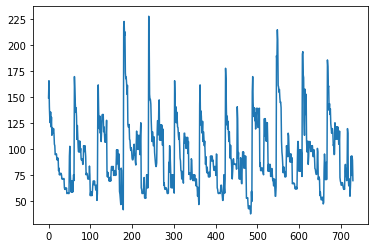

In [42]:
pyplot.plot(y_true)
pyplot.show()

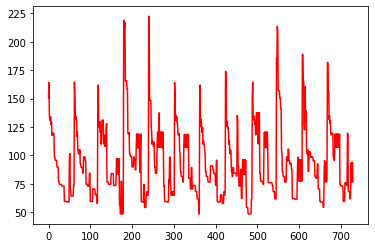

In [43]:
pyplot.plot(y_pred, color='red')
pyplot.show()

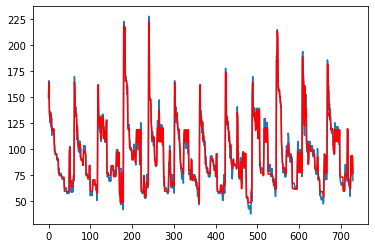

In [44]:
pyplot.plot(y_true)
pyplot.plot(y_pred, color='red')
pyplot.show()

In [46]:
data.iloc[0]

Distance in km                   4
City                        Mumbai
weather                     winter
Wieght                          25
Holiday                         no
Population Density           25357
Charge / Cost in Rupees    149.357
Name: 0, dtype: object

In [84]:
data_point = pd.DataFrame({
    "Distance in km":[4],
    'City': ["Mumbai"], 
    'weather ': ["winter"], 
    'Wieght': [25], 
    'Holiday': ["no"], 
    'Population Density': [25357]
})

In [85]:
logistic_company = "E-Dlvry"

In [86]:
encoder_file = open(os.path.join("feature_encoder","logistic_"+logistic_company+".obj"),'rb')
encoder_loaded = pickle.load(encoder_file)
encoder_file.close()

In [87]:
data_point_ohe = encoder_loaded.transform(data_point)

In [88]:
input_data_point = normalize(data_point_ohe, num_col, norm_val)
input_data_point

,Distance in km,City_1,City_2,weather _1,weather _2,weather _3,Wieght,Holiday_1,Holiday_2,Population Density
0,0.004,1,0,1,0,0,0.25,1,0,0.00002


In [89]:
model_file = open(os.path.join("trained_models","logistic_"+logistic_company+".pkl"),'rb')
model = pickle.load(model_file)
model_file.close()

In [90]:
model.predict(input_data_point)

array([150.05020825])